In [1]:
from pathlib import Path
data_path = ".\\DCC\\TST\\tst1s.mat"
pipe_path = ".\\DCC\\lpn-data-analysis\\"
import sys
import os
sys.path.append(data_path)
sys.path.append(pipe_path)
import data_tools
import validation_tools
import re
import itertools

import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
%matplotlib notebook

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import itertools
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split


if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

def mouse_Data_Extractor(data_shape,mice_labels,mice_to_remove):
    Row_Idxs = np.zeros(data_shape[0])    
    for i in range(len(Row_Idxs)):
        if mice_labels[i] in mice_to_remove:
            Row_Idxs[i] = True
        else:
            Row_Idxs[i] = False            
    return Row_Idxs == True
    
def brainRegionRemover(labels,regions_To_Remove,features):
    Idx = 0
        #power features
    if "power" in features:
        for i in range(len(regions_To_Remove)):
            for j in range(len(labels["powerFeatures"])):
                if regions_To_Remove[i] in labels["powerFeatures"][j]:
                    Idx.append(j)                
    return Idx

def batcher(X,batch_size=20):
    idx = np.random.choice(X.shape[0],size=batch_size,replace=False)
    return X[idx]

Running on the GPU


In [2]:
MAX_FREQ = 55
MIN_FREQ = 1
N_FOLDS = 5
MAX_N_TRAIN_MICE = 2
N_TARGET_TEST = 4
N_TARGET_TRAIN = 2
N_SOURCE_TRAIN = 14
TEST_SIZE = 0.2
N_UNIQUE_FEATURES = 605
N_FEATURES_TST = 605

In [3]:
tst_psd, tst_labels = data_tools.load_data(data_path,feature_list=['power'],f_bounds=(MIN_FREQ,MAX_FREQ))

areas = tst_labels['area']
unique_mice_names = np.unique(tst_labels['windows']['mouse'])
unique_mice_task = np.unique(tst_labels['windows']['task'])
mouse_name_labels = tst_labels['windows']['mouse']
mouse_geno_labels = tst_labels['windows']['genotype']
mouse_task_labels = tst_labels['windows']['task']
tst_mice_names_unique = np.unique(tst_labels['windows']['mouse'])
tst_mice_names = tst_labels['windows']['mouse']

Gene_0_mice = np.unique(np.array(tst_labels['windows']['mouse'])[np.array(tst_labels['windows']['genotype'],dtype=np.bool)==False])
Gene_1_mice = np.unique(np.array(tst_labels['windows']['mouse'])[np.array(tst_labels['windows']['genotype'],dtype=np.bool)==True])

shuffled_unique_names = np.random.choice(unique_mice_names,MAX_N_TRAIN_MICE+N_TARGET_TEST+N_SOURCE_TRAIN,replace=False)
shuffled_Gene_0_names = np.random.choice(Gene_0_mice,(MAX_N_TRAIN_MICE+N_TARGET_TEST+N_SOURCE_TRAIN)//2,replace=False)
shuffled_Gene_1_names = np.random.choice(Gene_1_mice,(MAX_N_TRAIN_MICE+N_TARGET_TEST+N_SOURCE_TRAIN)//2,replace=False)
Target_Test_Mice_Names = shuffled_Gene_0_names[:N_TARGET_TEST//2]
Target_Test_Mice_Names = np.append(Target_Test_Mice_Names,shuffled_Gene_1_names[:N_TARGET_TEST//2])
Target_Train_Mice_Names = shuffled_Gene_0_names[N_TARGET_TEST//2:(N_TARGET_TEST+N_TARGET_TRAIN)//2]
Target_Train_Mice_Names = np.append(Target_Train_Mice_Names,shuffled_Gene_1_names[N_TARGET_TEST//2:(N_TARGET_TEST+N_TARGET_TRAIN)//2])
Source_Train_Mice_Names = shuffled_Gene_0_names[(N_TARGET_TEST+N_TARGET_TRAIN)//2:(N_TARGET_TEST+N_TARGET_TRAIN+N_SOURCE_TRAIN)//2]
Source_Train_Mice_Names = np.append(Source_Train_Mice_Names,shuffled_Gene_1_names[(N_TARGET_TEST+N_TARGET_TRAIN)//2:(N_TARGET_TEST+N_TARGET_TRAIN+N_SOURCE_TRAIN)//2])

source_mouse_specific_idxs = []
target_mouse_specific_idxs = []
target_test_mouse_specific_idxs = []

target_train_psd_idxs = mouse_Data_Extractor(tst_psd.shape,tst_labels['windows']['mouse'],Target_Train_Mice_Names)
target_test_psd_idxs = mouse_Data_Extractor(tst_psd.shape,tst_labels['windows']['mouse'], Target_Train_Mice_Names)
source_train_psd_idxs = mouse_Data_Extractor(tst_psd.shape,tst_labels['windows']['mouse'],Source_Train_Mice_Names)
for mouse in Source_Train_Mice_Names:
    source_mouse_specific_idxs.append(mouse_Data_Extractor(tst_psd.shape,tst_labels['windows']['mouse'],mouse))
for mouse in Target_Train_Mice_Names:
    target_mouse_specific_idxs.append(mouse_Data_Extractor(tst_psd.shape,tst_labels['windows']['mouse'],mouse))    
for mouse in Target_Test_Mice_Names:
    target_test_mouse_specific_idxs.append(mouse_Data_Extractor(tst_psd.shape,tst_labels['windows']['mouse'],mouse))

train_idxs_source = []
val_idxs_source = []
test_idxs_source = []

train_idxs_target_train = []
val_idxs_target_train = []
test_idxs_target_train = []

train_idxs_target_test = []
val_idxs_target_test = []
test_idxs_target_test = []

for mouse in source_mouse_specific_idxs:
    train_idxs, test_idxs = train_test_split(np.where(mouse==True)[0],test_size=0.2)
    train_idxs, val_idxs = train_test_split(train_idxs,test_size=0.1)
    val_idxs_source.append(val_idxs)
    train_idxs_source.append(train_idxs)
    test_idxs_source.append(test_idxs)

full_train_idxs_source = [idx for sublist in train_idxs_source for idx in sublist]
full_val_idxs_source = [idx for sublist in val_idxs_source for idx in sublist]

for mouse in target_mouse_specific_idxs:
    train_idxs, test_idxs = train_test_split(np.where(mouse==True)[0],test_size=0.2)
    train_idxs, val_idxs = train_test_split(train_idxs,test_size=0.1)
    val_idxs_target_train.append(val_idxs)
    train_idxs_target_train.append(train_idxs)
    test_idxs_target_train.append(test_idxs)

full_train_idxs_target_train = [idx for sublist in train_idxs_target_train for idx in sublist]
full_val_idxs_target_train = [idx for sublist in val_idxs_target_train for idx in sublist]    
for mouse in target_test_mouse_specific_idxs:
    train_idxs, test_idxs = train_test_split(np.where(mouse==True)[0],test_size=0.2)
    train_idxs, val_idxs = train_test_split(train_idxs,test_size=0.1)
    val_idxs_target_test.append(val_idxs)
    train_idxs_target_test.append(train_idxs)
    test_idxs_target_test.append(test_idxs)
    
full_train_idxs_target_test = [idx for sublist in train_idxs_target_test for idx in sublist]
full_val_idxs_target_test = [idx for sublist in val_idxs_target_test for idx in sublist]

### Sklearn NMF model used for initialization

In [4]:
from sklearn.decomposition import NMF

X_train_init = tst_psd[full_train_idxs_source + full_train_idxs_target_train,:]
X_val = tst_psd[full_val_idxs_target_train,:]
init_Model = NMF(n_components=5)
z = init_Model.fit_transform(X_train_init)
W = init_Model.components_
W_init = W
print('MSE train NMF: ',np.mean((z.dot(W) - X_train_init)**2))
print('MSE val NMF: ',np.mean((init_Model.transform(X_val).dot(W) - X_val)**2))

MSE train NMF:  0.0830897616281648
MSE val NMF:  0.0709254800079981


In [5]:
print(np.linalg.matrix_rank(X_train_init))
print(np.linalg.matrix_rank(X_val))

88
247


In [6]:
(X_train_init - X_train_init.mean())

array([[ 2.9583492 ,  2.9249775 ,  2.6465452 , ..., -0.36684507,
        -0.36945963, -0.37330925],
       [ 0.38165388,  0.6612792 ,  1.0338022 , ..., -0.38214612,
        -0.3838491 , -0.38512176],
       [ 0.0473741 ,  0.10272831,  0.18197712, ..., -0.36351794,
        -0.3624165 , -0.3621562 ],
       ...,
       [ 1.1099347 ,  1.3839887 ,  1.575118  , ..., -0.38566944,
        -0.38414612, -0.38320652],
       [ 8.22711   ,  7.046937  ,  5.646152  , ..., -0.35614157,
        -0.36231863, -0.36424056],
       [ 0.796757  ,  0.9343872 ,  1.027908  , ..., -0.3719627 ,
        -0.37170172, -0.37315634]], dtype=float32)

In [7]:
class GradReverse(torch.autograd.Function):
    @staticmethod
    def forward(ctx,x):
        return x.view_as(x)
    
    @staticmethod
    def backward(ctx,grad_output):
        return grad_output.neg()
    
def grad_reverse(x):
    return GradReverse.apply(x)

In [8]:
class domain_style_encoders(nn.Module):
    
    def __init__(self,mouse_names,input_shapes,batch_size):
        super(domain_style_encoders,self).__init__()
        
        self.mouse_names = list(mouse_names)
        self.input_shapes = input_shapes
        self.batch_size= batch_size
        self.Encoder_List = nn.ModuleList().to('cuda:0')
        
        for mouse, input_shape in zip(mouse_names,input_shapes):
            self.Encoder_List.append(
                nn.Sequential(
                    nn.Linear(input_shape,input_shape),
                    nn.ELU(),
                    nn.Linear(input_shape,input_shape),
                    nn.ELU()
                ).to('cuda:0')
            )
            
    def forward(self,x,mouse_names):
        #print('domain style encoder')
        mouse_names = list(mouse_names)
        #This assumes that all inputs have the same input dimensionality
        x_dse_full = torch.Tensor(len(mouse_names)*self.batch_size,self.input_shapes[0]).to('cuda:0')
        
        for mouse in self.mouse_names:
            #print('in loop')
            mouse_idxs = (mouse_names.index(mouse)*self.batch_size,(mouse_names.index(mouse)+1)*self.batch_size)
            #print(mouse_idxs)
            #print(x.shape)
            x_dse = x[mouse_idxs[0]:mouse_idxs[1]] + self.Encoder_List[np.where(np.array(self.mouse_names)==mouse)[0][0]].forward(x[mouse_idxs[0]:mouse_idxs[1]])
            x_dse_full[mouse_idxs[0]:mouse_idxs[1]] = x_dse
            
        return x_dse_full                

In [9]:
class domain_style_decoders(nn.Module):
    def __init__(self,mouse_names,input_shapes,batch_size):
        super(domain_style_decoders,self).__init__()
        
        self.mouse_names = list(mouse_names)
        self.input_shapes = input_shapes
        self.Decoder_List = nn.ModuleList().to('cuda:0')
        self.batch_size = batch_size
        
        for mouse, input_shape in zip(mouse_names,input_shapes):
            self.Decoder_List.append(
                nn.Sequential(
                    nn.Linear(input_shape,input_shape),
                    nn.ELU(),
                    nn.Linear(input_shape,input_shape),
                    nn.ELU()
                ).to('cuda:0')
            )
    
    def forward(self,x,mouse_names):
        mouse_names = list(mouse_names)
        #This assumes that all inputs have the same input dimensionality
        x_dsd_full = torch.Tensor(len(mouse_names)*self.batch_size,self.input_shapes[0]).to('cuda:0')

        for mouse in self.mouse_names:
            mouse_idxs = (mouse_names.index(mouse)*self.batch_size,(mouse_names.index(mouse)+1)*self.batch_size)
            x_dsd = x[mouse_idxs[0]:mouse_idxs[1]] + self.Decoder_List[np.where(np.array(self.mouse_names)==mouse)[0][0]].forward(x[mouse_idxs[0]:mouse_idxs[1]])
            x_dsd_full[mouse_idxs[0]:mouse_idxs[1]] = x_dsd

        return x_dsd_full 
        

In [10]:
class shared_encoder_decoder(nn.Module):
    
    def __init__(self,mouse_names,input_shapes,n_components,W_init):
        super(shared_encoder_decoder,self).__init__()
        
        self.se_hidden_1 = 100
        self.n_components = n_components
        
        #Translation Parameters
        self.W_se = nn.Parameter(torch.rand((1,n_components)))
        self.b_se = nn.Parameter(torch.rand(n_components)) 
        
        #Define NMF Parameters
        self.W_nmf = nn.Parameter(torch.Tensor(W_init))
        
        
        self.Shared_Encoder = nn.Sequential(
            nn.Linear(input_shapes[0],self.se_hidden_1),
            nn.ReLU(),
            nn.Linear(self.se_hidden_1,self.n_components),
            nn.ReLU()
        ).to('cuda:0')
        
        self.se_mean = nn.Linear(self.n_components,self.n_components)
        self.se_logvar = nn.Linear(self.n_components,self.n_components)
        
        
    def Sampling(self,mean,log_var):
        eps = torch.randn(log_var.shape).to('cuda:0')
        sample = mean + torch.exp(log_var/2)*eps
        return sample 
    
    def forward(self,x):
        
        #encode
        x = self.Shared_Encoder(x)
        z_mean = self.se_mean(x)
        z_logvar = self.se_logvar(x)
        z_prime = self.Sampling(z_mean,z_logvar)
        z = F.softplus(z_prime * self.W_se + self.b_se)
        
        #decode
        x_recon = z @ F.relu(self.W_nmf)
        
        return (z_prime,z_logvar,z_mean,z), x_recon

In [11]:
class Cyc_VAE_Comp_Model(nn.Module):
    def __init__(self,mouse_names,input_shapes,n_components,batch_size,W_init):
        super(Cyc_VAE_Comp_Model,self).__init__()
        self.mouse_names = mouse_names
        self.dse_list = domain_style_encoders(mouse_names,input_shapes,batch_size).to('cuda:0')
        self.shared_e_d = shared_encoder_decoder(mouse_names,input_shapes,n_components,W_init)
        self.dsd_list = domain_style_decoders(mouse_names,input_shapes,batch_size).to('cuda:0')
        
    def forward(self,x):
        x = self.dse_list.forward(x,self.mouse_names)
        _,nmf_recon_x = self.shared_e_d.forward(x)
        x_dsd = self.dsd_list.forward(nmf_recon_x,self.mouse_names)
        
        return x,nmf_recon_x,x_dsd

In [29]:
all_mice_names = np.concatenate((Source_Train_Mice_Names,Target_Test_Mice_Names,Target_Train_Mice_Names))
input_shapes = [605 for mouse in all_mice_names]
model = shared_encoder_decoder(all_mice_names,input_shapes,n_components=5,W_init=W_init).to(device)
params = model.parameters()
optimizer = torch.optim.Adam(params,lr=1e-3)


same_domain_recon_loss = nn.MSELoss()
cycle_domain_recon_loss = nn.L1Loss()
style_transfer_layer_loss = nn.MSELoss()
#t_sda_loss = nn.BCELoss()
#s_sda_loss = nn.BCELoss()
sda_loss = nn.BCELoss()
lda_loss = nn.CrossEntropyLoss()
t_KLD_loss = nn.KLDivLoss(reduction='batchmean')
s_KLD_loss = nn.KLDivLoss(reduction='batchmean')

same_domain_recon_loss_history = []
cycle_domain_recon_loss_history = []
style_transfer_layer_loss_history = []
t_sda_loss_history = []
s_sda_loss_history = []
sda_loss_history = []
lda_loss_history = []
t_KLD_loss_history = []
s_KLD_loss_history = []

full_loss_history = []
val_loss_history = []

In [30]:
style_transfer_layer_loss = nn.L1Loss()

In [31]:
N_EPOCHS = 200
N_BATCHES = 30
BATCH_SIZE = 5

In [32]:
for epoch in range(N_EPOCHS):
    print(epoch)
    for batch in range(N_BATCHES):
        optimizer.zero_grad()
        #preallocate
        X_target_train_batches = torch.zeros(len(train_idxs_target_train)*BATCH_SIZE,605).to(device)
        X_target_test_batches = torch.zeros(len(train_idxs_target_test)*BATCH_SIZE,605).to(device)
        X_source_train_batches = torch.zeros(len(source_mouse_specific_idxs)*BATCH_SIZE,605).to(device)
        
        #batch training data
        for mouse_idx,idxs in enumerate(train_idxs_target_test):
            X_target_test_batches[mouse_idx*BATCH_SIZE:(mouse_idx+1)*BATCH_SIZE] = batcher(torch.Tensor(tst_psd[idxs]).to(device),batch_size=BATCH_SIZE)
        for mouse_idx,idxs in enumerate(train_idxs_target_train):
            X_target_train_batches[mouse_idx*BATCH_SIZE:(mouse_idx+1)*BATCH_SIZE] = batcher(torch.Tensor(tst_psd[idxs]).to(device),batch_size=BATCH_SIZE)
        for mouse_idx,idxs in enumerate(train_idxs_source):
            X_source_train_batches[mouse_idx*BATCH_SIZE:(mouse_idx+1)*BATCH_SIZE] = batcher(torch.Tensor(tst_psd[idxs]).to(device),batch_size=BATCH_SIZE)
        
        #combine training data
        X_cat = torch.cat((X_target_test_batches,X_target_train_batches,X_source_train_batches))
        
        #forward pass
        dist_tuple, x_recon = model.forward(X_cat)
        
        #save losses and step
        loss = same_domain_recon_loss(x_recon,X_cat)
        full_loss_history.append(loss)
        loss.backward()
        optimizer.step()
        
    #Validation Step
    val_X_target_train_batches = torch.zeros(len(train_idxs_target_train)*BATCH_SIZE,605).to(device)
    val_X_target_test_batches = torch.zeros(len(train_idxs_target_test)*BATCH_SIZE,605).to(device)
    val_X_source_train_batches = torch.zeros(len(source_mouse_specific_idxs)*BATCH_SIZE,605).to(device)

    for mouse_idx,idxs in enumerate(val_idxs_target_test):
        val_X_target_test_batches[mouse_idx*BATCH_SIZE:(mouse_idx+1)*BATCH_SIZE] = batcher(torch.Tensor(tst_psd[idxs]).to(device),batch_size=BATCH_SIZE)
    for mouse_idx,idxs in enumerate(val_idxs_target_train):
        val_X_target_train_batches[mouse_idx*BATCH_SIZE:(mouse_idx+1)*BATCH_SIZE] = batcher(torch.Tensor(tst_psd[idxs]).to(device),batch_size=BATCH_SIZE)
    for mouse_idx,idxs in enumerate(val_idxs_source):
        val_X_source_train_batches[mouse_idx*BATCH_SIZE:(mouse_idx+1)*BATCH_SIZE] = batcher(torch.Tensor(tst_psd[idxs]).to(device),batch_size=BATCH_SIZE)
    
    X_val = torch.cat((val_X_target_test_batches,val_X_target_train_batches,val_X_source_train_batches))
    
    val_dist_tuple, x_recon_val = model.forward(X_val)
    
    val_loss = same_domain_recon_loss(x_recon_val,X_val)
    
    val_loss_history.append(val_loss)
    
    if epoch % 10 == 0:
        print("training loss: ",loss)
        print("validation loss: ",val_loss)
        #print("sanity check, val: ",np.mean((X_val.detach().numpy() - x_recon_val.detach().numpy())**2))
    
           

0
training loss:  tensor(16.2638, device='cuda:0', grad_fn=<MseLossBackward>)
validation loss:  tensor(15.9709, device='cuda:0', grad_fn=<MseLossBackward>)
1
2
3
4
5
6
7
8
9
10
training loss:  tensor(6.8622, device='cuda:0', grad_fn=<MseLossBackward>)
validation loss:  tensor(6.3265, device='cuda:0', grad_fn=<MseLossBackward>)
11
12
13
14
15
16
17
18
19
20
training loss:  tensor(2.7959, device='cuda:0', grad_fn=<MseLossBackward>)
validation loss:  tensor(2.9975, device='cuda:0', grad_fn=<MseLossBackward>)
21
22
23
24
25
26
27
28
29
30
training loss:  tensor(1.4877, device='cuda:0', grad_fn=<MseLossBackward>)
validation loss:  tensor(1.4707, device='cuda:0', grad_fn=<MseLossBackward>)
31
32
33
34
35
36
37
38
39
40
training loss:  tensor(1.0374, device='cuda:0', grad_fn=<MseLossBackward>)
validation loss:  tensor(1.1746, device='cuda:0', grad_fn=<MseLossBackward>)
41
42
43
44
45
46
47
48
49
50
training loss:  tensor(0.6541, device='cuda:0', grad_fn=<MseLossBackward>)
validation loss:  te

In [39]:
print(len(val_loss_history))

print(len(full_loss_history))

200
6000


<IPython.core.display.Javascript object>


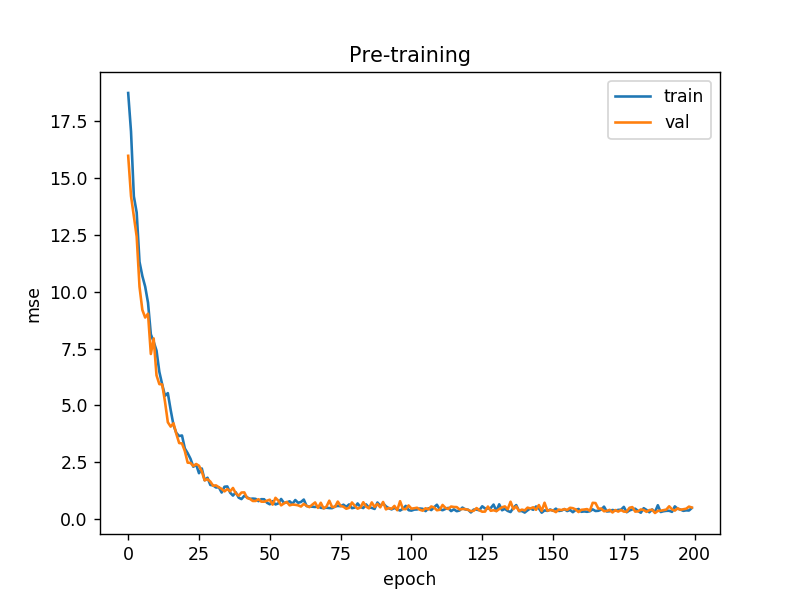

In [40]:
plt.plot(full_loss_history[::30],label='train')
plt.plot(val_loss_history,label='val')
plt.title("losses")
plt.xlabel('epoch')
plt.ylabel('mse')
plt.title('Pre-training')
plt.legend()
plt.show()

In [63]:
model_2 = Cyc_VAE_Comp_Model(all_mice_names,input_shapes,n_components=5,batch_size=5,W_init=W_init).to(device)
model_2.shared_e_d = model
params_2 = model_2.parameters()

optimizer_2 = torch.optim.Adam(params_2,lr=1e-3)
full_loss_history_2 = []
val_loss_history_2 = []

In [64]:
N_EPOCHS = 100
N_BATCHES = 30
BATCH_SIZE = 5

In [65]:
for epoch in range(N_EPOCHS):
    #print(epoch)
    for batch in range(N_BATCHES):
        optimizer_2.zero_grad()
        #preallocate
        X_target_train_batches = torch.zeros(len(train_idxs_target_train)*BATCH_SIZE,605).to(device)
        X_target_test_batches = torch.zeros(len(train_idxs_target_test)*BATCH_SIZE,605).to(device)
        X_source_train_batches = torch.zeros(len(source_mouse_specific_idxs)*BATCH_SIZE,605).to(device)
        
        #batch training data
        for mouse_idx,idxs in enumerate(train_idxs_target_test):
            X_target_test_batches[mouse_idx*BATCH_SIZE:(mouse_idx+1)*BATCH_SIZE] = batcher(torch.Tensor(tst_psd[idxs]).to(device),batch_size=BATCH_SIZE)
        for mouse_idx,idxs in enumerate(train_idxs_target_train):
            X_target_train_batches[mouse_idx*BATCH_SIZE:(mouse_idx+1)*BATCH_SIZE] = batcher(torch.Tensor(tst_psd[idxs]).to(device),batch_size=BATCH_SIZE)
        for mouse_idx,idxs in enumerate(train_idxs_source):
            X_source_train_batches[mouse_idx*BATCH_SIZE:(mouse_idx+1)*BATCH_SIZE] = batcher(torch.Tensor(tst_psd[idxs]).to(device),batch_size=BATCH_SIZE)
        
        #combine training data
        X_cat = torch.cat((X_target_test_batches,X_target_train_batches,X_source_train_batches)).to('cuda:0')
        
        #forward pass
        x_dse, x_recon,x_dsd = model_2.forward(X_cat)
        
        #save losses and step
        loss = same_domain_recon_loss(x_dsd,X_cat) 
        loss_dsd = style_transfer_layer_loss(x_dsd,x_recon)
        full_loss = loss + 10*loss_dsd
        full_loss_history_2.append(full_loss)
        full_loss.backward()
        optimizer_2.step()
        
    #Validation Step
    val_X_target_train_batches = torch.zeros(len(train_idxs_target_train)*BATCH_SIZE,605).to(device)
    val_X_target_test_batches = torch.zeros(len(train_idxs_target_test)*BATCH_SIZE,605).to(device)
    val_X_source_train_batches = torch.zeros(len(source_mouse_specific_idxs)*BATCH_SIZE,605).to(device)

    for mouse_idx,idxs in enumerate(val_idxs_target_test):
        val_X_target_test_batches[mouse_idx*BATCH_SIZE:(mouse_idx+1)*BATCH_SIZE] = batcher(torch.Tensor(tst_psd[idxs]).to(device),batch_size=BATCH_SIZE)
    for mouse_idx,idxs in enumerate(val_idxs_target_train):
        val_X_target_train_batches[mouse_idx*BATCH_SIZE:(mouse_idx+1)*BATCH_SIZE] = batcher(torch.Tensor(tst_psd[idxs]).to(device),batch_size=BATCH_SIZE)
    for mouse_idx,idxs in enumerate(val_idxs_source):
        val_X_source_train_batches[mouse_idx*BATCH_SIZE:(mouse_idx+1)*BATCH_SIZE] = batcher(torch.Tensor(tst_psd[idxs]).to(device),batch_size=BATCH_SIZE)
    
    X_val = torch.cat((val_X_target_test_batches,val_X_target_train_batches,val_X_source_train_batches))
    
    val_x_dse, val_x_recon, val_x_dsd = model_2.forward(X_val)
    
    val_loss = same_domain_recon_loss(val_x_dsd,X_val) + style_transfer_layer_loss(val_x_dsd,x_recon)
    
    val_loss_history_2.append(val_loss)
    
    if epoch % 10 == 0:
        print(epoch)
        print("\ntraining loss: ",loss , '\nmost recent dsd loss: ',loss_dsd)
        print("\nvalidation loss: ",same_domain_recon_loss(val_x_dsd,X_val), 
              '\nmost recent dsd loss: ',style_transfer_layer_loss(val_x_dsd,x_recon))

0

training loss:  tensor(0.9529, device='cuda:0', grad_fn=<MseLossBackward>) 
most recent dsd loss:  tensor(0.0030, device='cuda:0', grad_fn=<MeanBackward0>)

validation loss:  tensor(0.9751, device='cuda:0', grad_fn=<MseLossBackward>) 
most recent dsd loss:  tensor(0.0148, device='cuda:0', grad_fn=<MeanBackward0>)
10

training loss:  tensor(0.5999, device='cuda:0', grad_fn=<MseLossBackward>) 
most recent dsd loss:  tensor(0.0140, device='cuda:0', grad_fn=<MeanBackward0>)

validation loss:  tensor(0.4308, device='cuda:0', grad_fn=<MseLossBackward>) 
most recent dsd loss:  tensor(0.1221, device='cuda:0', grad_fn=<MeanBackward0>)
20

training loss:  tensor(0.3854, device='cuda:0', grad_fn=<MseLossBackward>) 
most recent dsd loss:  tensor(0.0100, device='cuda:0', grad_fn=<MeanBackward0>)

validation loss:  tensor(0.3685, device='cuda:0', grad_fn=<MseLossBackward>) 
most recent dsd loss:  tensor(0.1237, device='cuda:0', grad_fn=<MeanBackward0>)
30

training loss:  tensor(0.3347, device='c

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


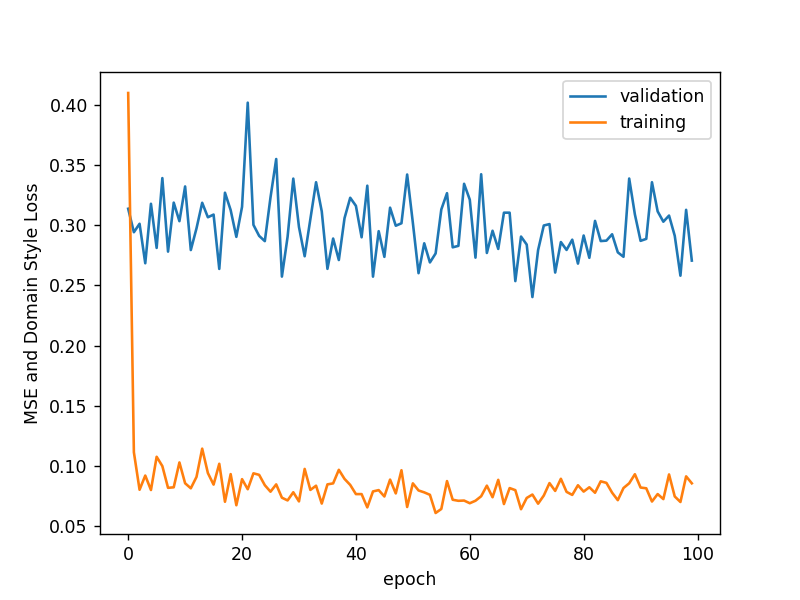

In [47]:
plt.plot(val_loss_history_2,label='validation')
plt.plot(full_loss_history_2[::30],label='training')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('MSE and Domain Style Loss')
plt.show()